# Generate cellxgene

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

# Prepare INPUT

## Load raw and annoted andata

In [2]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [3]:
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')
adata = adata[[i in 'male' for i in adata.obs.sex]]
adata.X.shape

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(152593, 28820)

In [4]:
adata_annotated = sc.read(path_to_gonads+'/FCA-gonads_male_annotated.h5ad')
adata_annotated.X.shape

(152593, 26615)

### Import lineage and somatic annotation

In [5]:
cell_annot = adata_annotated.obs['lineage'].to_dict()
adata.obs['lineage'] = adata.obs_names.map(cell_annot)
adata.obs['lineage'].value_counts()

Trying to set attribute `.obs` of view, copying.


Mesenchymal_GATA2    35569
Mesenchymal_LHX9     35131
Sertoli              34969
lowQC                12875
Endothelial           6122
Doublet               3980
Supporting            3956
Epithelial            3727
GermCells             3624
Immune                2906
CoelEpi               2886
FetalLeydig           2426
PV                    2341
Neural                1519
Erythroid              508
cont                    54
Name: lineage, dtype: int64

In [6]:
# Add somatic cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_somatic_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['celltype'].to_dict()
adata.obs['lineageSomatic'] = adata.obs_names.map(cell_annot)
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].fillna(adata.obs['lineage'])
adata.obs['lineageSomatic'] = adata.obs['lineageSomatic'].astype('category')
adata.obs['lineageSomatic'].value_counts()

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Mesenchymal_GATA2       35569
Sertoli                 35282
Ti                      33289
lowQC                   12798
Endothelial              6122
Doublet                  3980
Epithelial               3727
GermCells                3624
Immune                   2906
FetalLeydig              2793
PV                       2341
late_sPAX8               2046
CoelEpi_LHX9             1985
Neural                   1519
cont                     1269
CoelEpi_GATA2             699
early_sPAX8               563
Erythroid                 508
early_somatic             410
Oi                        264
Gi                        182
early_supporting          165
CoelEpi_LHX9_cycling      146
Supporting                132
preGC_IIa                  86
preGC_I                    66
CoelEpi                    58
OSE                        45
preGC_IIb                  10
Mesenchymal_LHX9            9
Name: lineageSomatic, dtype: int64

## Remove lowQC cells and artifacts

In [7]:
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont', 'Mesenchymal_LHX9', 'Supporting', 'CoelEpi', 'OSE', 'preGC_I', 'preGC_IIa', 'preGC_IIb', 'Oi'] for i in adata.obs.lineageSomatic]]

In [8]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()

Total number of cells: 133811
Total number of genes: 28820


,counts,freqs
categories,,
F88,9734,0.072744
F93,44,0.000329
F100,2144,0.016023
F122,17165,0.128278
Hrv3,3123,0.023339
Hrv10,5074,0.037919
Hrv15,1013,0.007570
Hrv16,704,0.005261
Hrv17,6148,0.045945


## Import UMAP

In [9]:
adata_annotated = adata_annotated[[ i in adata.obs_names for i in adata_annotated.obs_names ]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [10]:
adata.obsm['X_umap'] = adata_annotated.obsm['X_umap']
adata.obsm['X_scVI'] = adata_annotated.obsm['X_scVI']
# adata.obsp['connectivities'] = adata_annotated.obsp['connectivities']
# adata.obsp['distances'] = adata_annotated.obsp['distances']
# adata.uns['celltype_colors'] = adata_annotated.uns['celltype_colors']
# adata.uns['neighbors'] = adata_annotated.uns['neighbors']

## Remove un necessary data

In [11]:
del adata_annotated

In [12]:
del adata.obs['study']
del adata.obs['stage']
del adata.obs['batch_collection']
del adata.obs['lineages_v1']
del adata.obs['celltype_v1']
del adata.obs['lineage_v2']
del adata.obs['somatic_celltype_v2']
del adata.obs['batch']

# Normalize data

In [13]:
adata.raw = adata.copy()

In [14]:
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)                                                                                                            
# sc.pp.scale(adata, max_value=10)

... storing 'lineage' as categorical


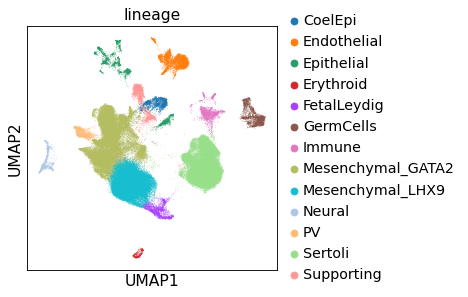

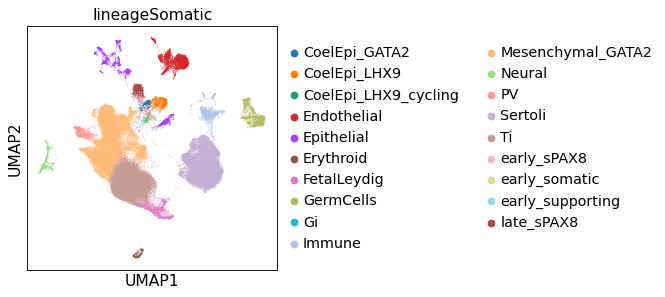

In [15]:
sc.pl.umap(adata, color='lineage')
sc.pl.umap(adata, color='lineageSomatic')

In [16]:
adata.write('/nfs/cellgeni/tickets/tic-613/human_main_male.h5ad')